In [1]:
import os
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import random

# importo los .py
import sys
sys.path.append("aux")
import transformaciones

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
#arch_sellout = "datasets/emp3_sellout_base.csv"
arch_sellout = "datasets/emp3_sellout_base_muestra.csv"

arch_min_max_prod_cust = "datasets/emp3_min_max_prod_cust.csv"
arch_mean_std_prod_cust = "datasets/emp3_mean_std_prod_cust.csv"
arch_no_transf_prod_cust = "datasets/emp3_no_transf_prod_cust.csv"

arch_salida = "datasets/emp3_sellout_transf.csv"

In [4]:
# Marco en train, holdout y descartar para considerarlo en las transformaciones
periodo_inicio=201701 #inclusive
train_periodo_limite = 201810 #inclusive
validate_periodo = 201812
train_all_periodo_limite = 201812 #inclusive
holdout_periodo = 201902

In [5]:
tipos_transf = ['sin_transformacion', 'normalizacion', 'estandarizacion']
TIPO_TRANSF = tipos_transf[2]

In [6]:
def normalizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["prod_cust","tn"]]
    
    #Calculo min max por producto y lo guardo para poder revertir posteriormente
    df_min_max_prod_cust = df_train.groupby('prod_cust')['tn'].agg(['max', 'min']).reset_index()
    df_min_max_prod_cust = df_min_max_prod_cust.rename(columns={"min":"valor_1","max":"valor_2"})
    df_min_max_prod_cust.valor_1 = 0
    df_min_max_prod_cust.to_csv(arch_min_max_prod_cust, index=False)
        
    df_ret = df_param.merge(df_min_max_prod_cust,how="left",on="prod_cust") #puede haber pares <prod-cust> que no aparezcan, por eso left
    
    # Selecciono columnas a normalizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn

    # Transformo
    df_ret["tn"] =df_ret.apply(lambda row: transformaciones.normalizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
    df_ret["cust_request_tn"] =df_ret.apply(lambda row: transformaciones.normalizar_valor(row["cust_request_tn"],row["valor_1"],row["valor_2"]),axis=1)

    # Columna Control
    df_ret["tn_reconstruido"] =df_ret.apply(lambda row: transformaciones.desnormalizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)

    return df_ret

def estandarizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["prod_cust","tn"]]
    
    #Calculo media y desvio por producto y lo guardo para poder revertir posteriormente
    df_mean_std_prod_cust = df_train.groupby('prod_cust')['tn'].agg(['mean', lambda x: np.std(x,ddof=0)]).reset_index() #se usa ddof=0 para evitar NaN cuando hay un solo producto
    df_mean_std_prod_cust.columns = ["prod_cust",'valor_1', 'valor_2']
    df_mean_std_prod_cust.to_csv(arch_mean_std_prod_cust, index=False)
        
    df_ret = df_param.merge(df_mean_std_prod_cust,how="left",on="prod_cust")
   
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn

    # Transformo
    df_ret["tn"] =df_ret.apply(lambda row: transformaciones.estandarizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
    df_ret["cust_request_tn"] =df_ret.apply(lambda row: transformaciones.estandarizar_valor(row["cust_request_tn"],row["valor_1"],row["valor_2"]),axis=1)

    # Columna de Control
    df_ret["tn_reconstruido"] =df_ret.apply(lambda row: transformaciones.desestandarizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

def no_transformar_tn(df_param):
    #Completo con 0s porque no se transformara nada
    df_no_transf_prod_cust = pd.DataFrame(data={"prod_cust":df_param.prod_cust.unique()})
    df_no_transf_prod_cust["valor_1"]=0
    df_no_transf_prod_cust["valor_2"]=0
    df_no_transf_prod_cust.to_csv(arch_no_transf_prod_cust, index=False)
        
    df_ret = df_param.merge(df_no_transf_prod_cust,how="left",on="prod_cust")
   
    df_ret["tn_original"]=df_ret.tn
    df_ret["tn_reconstruido"]=df_ret.tn
    
    return df_ret

############# AUXILIARES
def graficar_ejemplo_transformacion(df_param):
    prod_cust = np.array(df_param.sample(1).prod_cust)[0]
    df_param = df_param[df_param.prod_cust==prod_cust]
    
    plt.plot(df_param.tn_original)
    plt.title("Original - " + prod_cust)
    plt.show()
    
    plt.plot(df_param.tn)
    plt.title("Transformado - " + prod_cust)
    plt.show()

def transformar_df(tipo_transf, df_param):
    if TIPO_TRANSF == "sin_transformacion":
        print("\nSin Transformacion")
        
        print(len(df_sellout))
        df_sellout_transf = no_transformar_tn(df_sellout)
        print(len(df_sellout_transf))     
                
    elif TIPO_TRANSF == "normalizacion":
        print("Normalizacion")
        
        print(len(df_sellout))
        df_sellout_transf = normalizar_tn(df_sellout)
        print(len(df_sellout_transf))
    
    elif TIPO_TRANSF == "estandarizacion":
        print("Estandarizacion")
        
        print(len(df_sellout))
        df_sellout_transf = estandarizar_tn(df_sellout)
        print(len(df_sellout_transf))

    return df_sellout_transf

## Transformación

In [7]:
df_sellout = pd.read_csv(arch_sellout)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133681 entries, 0 to 133680
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   product_id                 133681 non-null  int64  
 1   periodo                    133681 non-null  int64  
 2   customer_id                133681 non-null  int64  
 3   cero_ventas                133681 non-null  int64  
 4   plan_precios_cuidados      133681 non-null  float64
 5   cust_request_qty           133681 non-null  float64
 6   cust_request_tn            133681 non-null  float64
 7   tn                         133681 non-null  float64
 8   periodo_fecha              133681 non-null  object 
 9   mes                        133681 non-null  int64  
 10  meses_historia_prod        133681 non-null  int64  
 11  meses_historia_cliente     133681 non-null  int64  
 12  cliente_estrella           133681 non-null  int64  
 13  prod_cust                  13

In [8]:
correlation = df_sellout.tn.corr(df_sellout.cust_request_tn)
print("Correlacion entre tn y cust_request_tn:", correlation)

Correlacion entre tn y cust_request_tn: 0.9963714751109147


--> es tan alta que las transformo con la misma escala

In [9]:
df_sellout_transf = transformar_df(TIPO_TRANSF,df_sellout)

Estandarizacion
133681
133681


In [10]:
df_sellout_transf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133681 entries, 0 to 133680
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   product_id                 133681 non-null  int64  
 1   periodo                    133681 non-null  int64  
 2   customer_id                133681 non-null  int64  
 3   cero_ventas                133681 non-null  int64  
 4   plan_precios_cuidados      133681 non-null  float64
 5   cust_request_qty           133681 non-null  float64
 6   cust_request_tn            133681 non-null  float64
 7   tn                         133681 non-null  float64
 8   periodo_fecha              133681 non-null  object 
 9   mes                        133681 non-null  int64  
 10  meses_historia_prod        133681 non-null  int64  
 11  meses_historia_cliente     133681 non-null  int64  
 12  cliente_estrella           133681 non-null  int64  
 13  prod_cust                  13

In [11]:
# Control (puede haber un margen de error)
print(df_sellout_transf.tn_original.sum())
print(df_sellout_transf.tn_reconstruido.sum())

11293.02663
11183.951790000003


## Generación de Target

In [12]:
df_sellout_transf = df_sellout_transf.sort_values(by=["prod_cust","periodo"],ascending=True)
df_sellout_transf["tn_mas_2"] = df_sellout_transf.groupby("prod_cust")['tn'].shift(-2)
df_sellout_transf["tn_mas_2_original"] = df_sellout_transf.groupby("prod_cust")['tn_original'].shift(-2)

In [13]:
# Control visual
df_sellout_transf[["prod_cust","periodo","tn","tn_mas_2","tn_original","tn_mas_2_original","valor_1","valor_2"]].head(50)

,prod_cust,periodo,tn,tn_mas_2,tn_original,tn_mas_2_original,valor_1,valor_2
0,20001-10009,201701,-0.28,-0.33,15.27,14.41,19.60,15.73
1,20001-10009,201702,0.12,-0.89,21.55,5.54,19.60,15.73
2,20001-10009,201703,-0.33,0.87,14.41,33.24,19.60,15.73
3,20001-10009,201704,-0.89,1.66,5.54,45.67,19.60,15.73
4,20001-10009,201705,0.87,-1.09,33.24,2.46,19.60,15.73
5,20001-10009,201706,1.66,2.84,45.67,64.27,19.60,15.73
6,20001-10009,201707,-1.09,-1.09,2.46,2.46,19.60,15.73
7,20001-10009,201708,2.84,-1.07,64.27,2.72,19.60,15.73
8,20001-10009,201709,-1.09,0.26,2.46,23.75,19.60,15.73
9,20001-10009,201710,-1.07,1.26,2.72,39.40,19.60,15.73


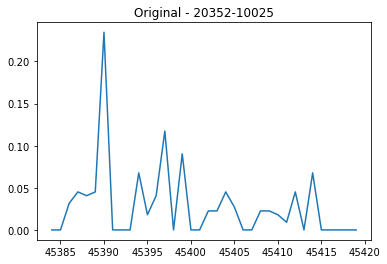

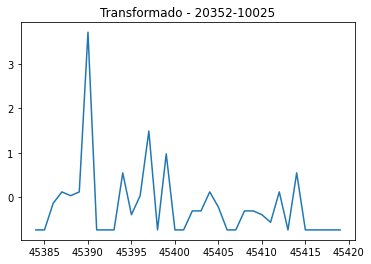

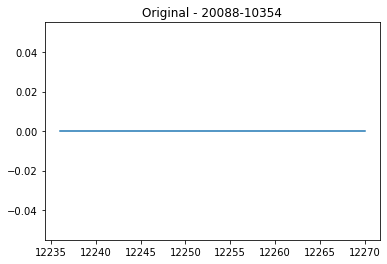

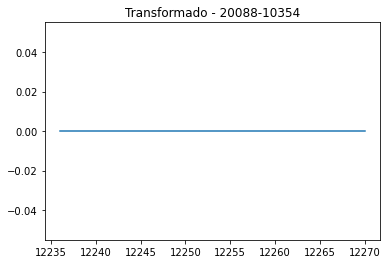

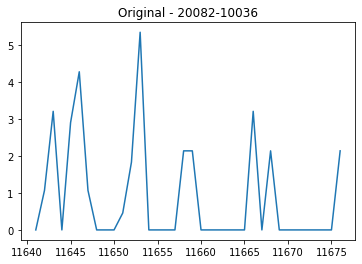

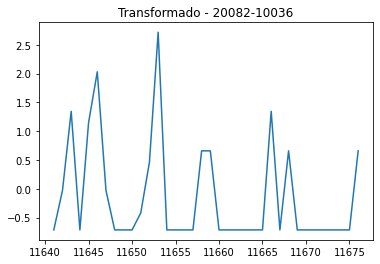

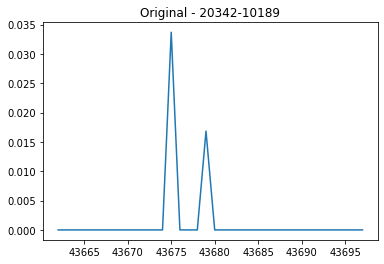

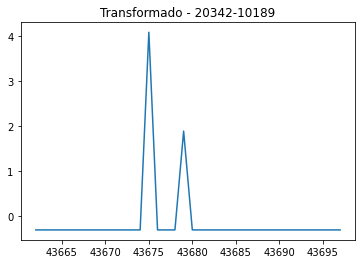

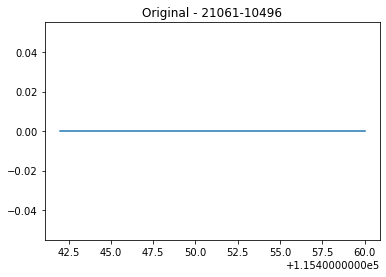

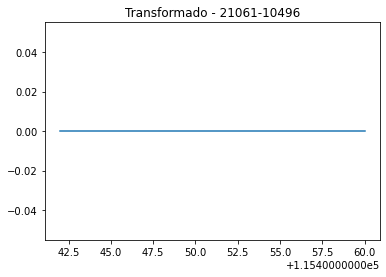

In [14]:
# Control visual de algunas series transformadas
for i in range(0,5):
    graficar_ejemplo_transformacion(df_sellout_transf)

In [15]:
# Se eliminar columnas de control (tn_mas_2_original la mantengo porque la uso para el error_rate durante validacion y testeo)
df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","tn_reconstruido","valor_1","valor_2"])

df_sellout_transf.to_csv(arch_salida,index=False)
len(df_sellout_transf)

133681

In [16]:
df_sellout_transf.columns

Index(['product_id', 'periodo', 'customer_id', 'cero_ventas',
       'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'tn',
       'periodo_fecha', 'mes', 'meses_historia_prod', 'meses_historia_cliente',
       'cliente_estrella', 'prod_cust', 'cat1', 'cat2', 'cat3', 'brand',
       'sku_size', 'producto_estrella', 'temp_media', 'temp_max_media',
       'temp_min_media', 'IPC', 'promedio_mens_dolar_venta', 'catastrofe',
       'tn_mas_2', 'tn_mas_2_original'],
      dtype='object')

In [17]:
df_sellout_transf.isna().sum()

product_id                      0
periodo                         0
customer_id                     0
cero_ventas                     0
plan_precios_cuidados           0
cust_request_qty                0
cust_request_tn                 0
tn                              0
periodo_fecha                   0
mes                             0
meses_historia_prod             0
meses_historia_cliente          0
cliente_estrella                0
prod_cust                       0
cat1                            0
cat2                            0
cat3                            0
brand                           0
sku_size                        0
producto_estrella               0
temp_media                      0
temp_max_media                  0
temp_min_media                  0
IPC                             0
promedio_mens_dolar_venta       0
catastrofe                      0
tn_mas_2                     9971
tn_mas_2_original            9971
dtype: int64

In [18]:
df_sellout_transf[df_sellout_transf.tn_mas_2.isna()].periodo.unique()

array([201911, 201912])

--> ok que sean solamente estos meses